In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw
import pmdarima as pm


In [16]:

# Generate the Synthetic Time Series
def generate_time_series(seed=66):
    np.random.seed(seed)
    t = np.arange(1, 1001)  
    f0 = 0.2
    phi = (t / 100) ** 2   
    modif_ts1 = np.cos(2 * np.pi * f0 * t / 10 + phi * 2 * np.pi)
    ploy = ((t - 500) ** 2) / (500 ** 2) + 0.5
    noise_intensity = 0.3
    white_noise = np.random.normal(loc=0, scale=noise_intensity, size=len(modif_ts1))
    ts = (modif_ts1 + white_noise) * ploy
    return ts


# Simulate a Gap in the Time Series

def simulate_gap(ts, gap_start, gap_end):
    """
    Introduce a gap by setting indices gap_start to gap_end (inclusive) to np.nan.
    (R's gaps=200:249 in 1-indexed terms corresponds to Python indices 199 to 248.)
    """
    ts_gap = ts.copy()
    ts_gap[gap_start:gap_end+1] = np.nan
    return ts_gap

In [17]:
# Algorithm 1: Euclidean Distance-Based Matching
def algorithm1_interpolate(ts, gap_indices, seg_len):
    """
    Uses a long window (seg_len) centered on the gap.
    Slides the window over the series (skipping candidates with missing values or overlap with gap)
    and computes Euclidean distance (on the context outside the gap) to choose the best match.
    """
    ts_filled = ts.copy()
    gap_indices = np.array(gap_indices)
    gap_len = len(gap_indices)
    pad = (seg_len - gap_len) // 2

    # Define the window that contains the gap.
    window_start = gap_indices[0] - pad
    window_end = window_start + seg_len
    if window_start < 0:
        window_start = 0
        window_end = seg_len
    if window_end > len(ts):
        window_end = len(ts)
        window_start = window_end - seg_len
    gappy_segment = ts[window_start:window_end]
    gap_relative_indices = np.arange(pad, pad + gap_len)
    
    best_distance = np.inf
    best_candidate = None
    # Slide a candidate window of length seg_len over the series.
    for i in range(0, len(ts) - seg_len + 1):
        candidate_window = ts[i:i+seg_len]
        if np.isnan(candidate_window).any():
            continue
        candidate_indices = np.arange(i, i+seg_len)
        if np.intersect1d(candidate_indices, gap_indices).size > 0:
            continue
        non_gap_indices = np.setdiff1d(np.arange(seg_len), gap_relative_indices)
        distance = np.linalg.norm(candidate_window[non_gap_indices] - gappy_segment[non_gap_indices])
        if distance < best_distance:
            best_distance = distance
            best_candidate = candidate_window
    if best_candidate is not None:
        ts_filled[gap_indices] = best_candidate[gap_relative_indices]
    else:
        print("No matching segment found for Algorithm 1.")
    return ts_filled

In [18]:
# Algorithm 2:DTW-Based Matching using tslearn
def algorithm_dtw_interpolate_tslearn(ts, gap_indices, seg_len):
    """
    Uses tslearn’s DTW to find the best matching candidate segment.
    The method is similar to Algorithm 1 but computes DTW distance (on the non-gap context)
    between the window containing the gap and candidate windows.
    """
    ts_filled = ts.copy()
    gap_indices = np.array(gap_indices)
    gap_len = len(gap_indices)
    pad = (seg_len - gap_len) // 2

    # Define the window that contains the gap.
    window_start = gap_indices[0] - pad
    window_end = window_start + seg_len
    if window_start < 0:
        window_start = 0
        window_end = seg_len
    if window_end > len(ts):
        window_end = len(ts)
        window_start = window_end - seg_len
    gappy_segment = ts[window_start:window_end]
    gap_relative_indices = np.arange(pad, pad + gap_len)

    best_distance = np.inf
    best_candidate = None
    for i in range(0, len(ts) - seg_len + 1):
        candidate_window = ts[i:i+seg_len]
        if np.isnan(candidate_window).any():
            continue
        candidate_indices = np.arange(i, i+seg_len)
        if np.intersect1d(candidate_indices, gap_indices).size > 0:
            continue
        non_gap_indices = np.setdiff1d(np.arange(seg_len), gap_relative_indices)
        distance = dtw(candidate_window[non_gap_indices], gappy_segment[non_gap_indices])
        if distance < best_distance:
            best_distance = distance
            best_candidate = candidate_window
    if best_candidate is not None:
        ts_filled[gap_indices] = best_candidate[gap_relative_indices]
    else:
        print("No matching segment found for DTW-based algorithm (tslearn).")
    return ts_filled

In [19]:
# Algorithm 3: Arima-based Interpolation
def algorithm_arima_interpolate_pmdarima(ts, gap_indices):
    """
    Fills the gap using an ARIMA model from pmdarima.
    Since pmdarima cannot directly handle missing values, first fill gaps via linear interpolation,
    then fit an ARIMA model using auto_arima and replace the gap with the model's in-sample predictions.
    """
    ts_filled = ts.copy()
    n = len(ts_filled)
    x = np.arange(n)
    not_nan = ~np.isnan(ts_filled)
    ts_interp = ts_filled.copy()
    ts_interp[np.isnan(ts_interp)] = np.interp(x[np.isnan(ts_interp)], x[not_nan], ts_filled[not_nan])
    
    # Fit an ARIMA model on the interpolated series.
    model = pm.auto_arima(ts_interp, seasonal=False, error_action='ignore', suppress_warnings=True)
    preds = model.predict_in_sample()
    
    # Replace gap values with ARIMA in-sample predictions.
    ts_result = ts.copy()
    ts_result[gap_indices] = preds[gap_indices]
    return ts_result


In [21]:
# Algorithm 4: Iterative Local Matching (R-style)
def fill_gap_rstyle(ts, gap_indices, radius):
    """
    For each gap index, extract a local window from max(0, gap - radius)
    to min(len(ts)-1, gap + radius) (inclusive) and fill the gap with the first element
    of that local window, mimicking R's recycling behavior.
    """
    ts_filled = ts.copy()
    for gap in gap_indices:
        if np.isnan(ts_filled[gap]):
            start = max(0, gap - radius)
            end = min(len(ts_filled)-1, gap + radius) + 1  # inclusive slice
            local_window = ts_filled[start:end]
            ts_filled[gap] = local_window[0]
    return ts_filled

Algorithm 1 (Euclidean) RMSE: 0.7251516520664371
Radius: 1, RMSE: 1.0182
Radius: 2, RMSE: 0.9641
Radius: 3, RMSE: 0.8564
Radius: 4, RMSE: 0.8187
Radius: 5, RMSE: 0.8096
Radius: 6, RMSE: 0.8087
Radius: 7, RMSE: 0.8269
Radius: 8, RMSE: 0.8523
Radius: 9, RMSE: 0.8612
Radius: 10, RMSE: 0.8481
Radius: 11, RMSE: 0.8380
Radius: 12, RMSE: 0.8073
Radius: 13, RMSE: 0.8948
Radius: 14, RMSE: 0.8113
Radius: 15, RMSE: 0.5370
Radius: 16, RMSE: 0.3664
Radius: 17, RMSE: 0.5452
Radius: 18, RMSE: 0.7968
Radius: 19, RMSE: 0.9087
Radius: 20, RMSE: 0.9205
Radius: 21, RMSE: 0.8489
Radius: 22, RMSE: 0.8324
Radius: 23, RMSE: 0.8234
Radius: 24, RMSE: 0.8737
Radius: 25, RMSE: 0.9550
Radius: 26, RMSE: 1.0500
Radius: 27, RMSE: 1.1254
Radius: 28, RMSE: 1.1290
Radius: 29, RMSE: 1.0092
Radius: 30, RMSE: 0.8675
Radius: 31, RMSE: 0.6441
Radius: 32, RMSE: 0.4545
Radius: 33, RMSE: 0.4204
Radius: 34, RMSE: 0.5647
Radius: 35, RMSE: 0.7796
Radius: 36, RMSE: 0.9119
Radius: 37, RMSE: 0.9933
Radius: 38, RMSE: 1.0072
Radius: 39

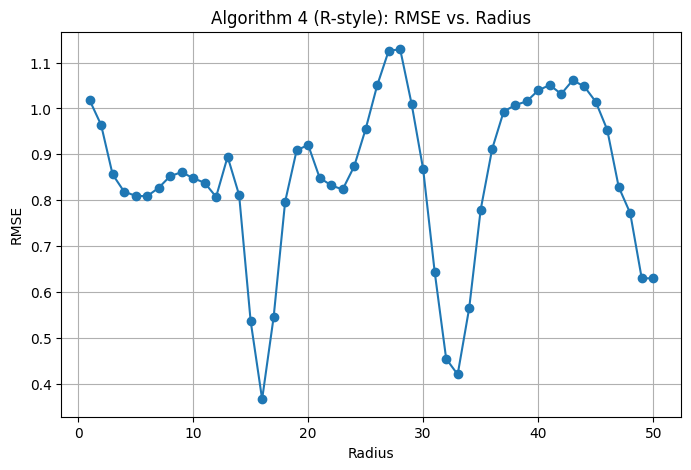

Best Radius for Algorithm 4 (R-style): 16 with RMSE: 0.3664
DTW-based (tslearn) Algorithm RMSE: 0.6997007900015517
ARIMA-based (pmdarima) Algorithm RMSE: 0.6703836913678695


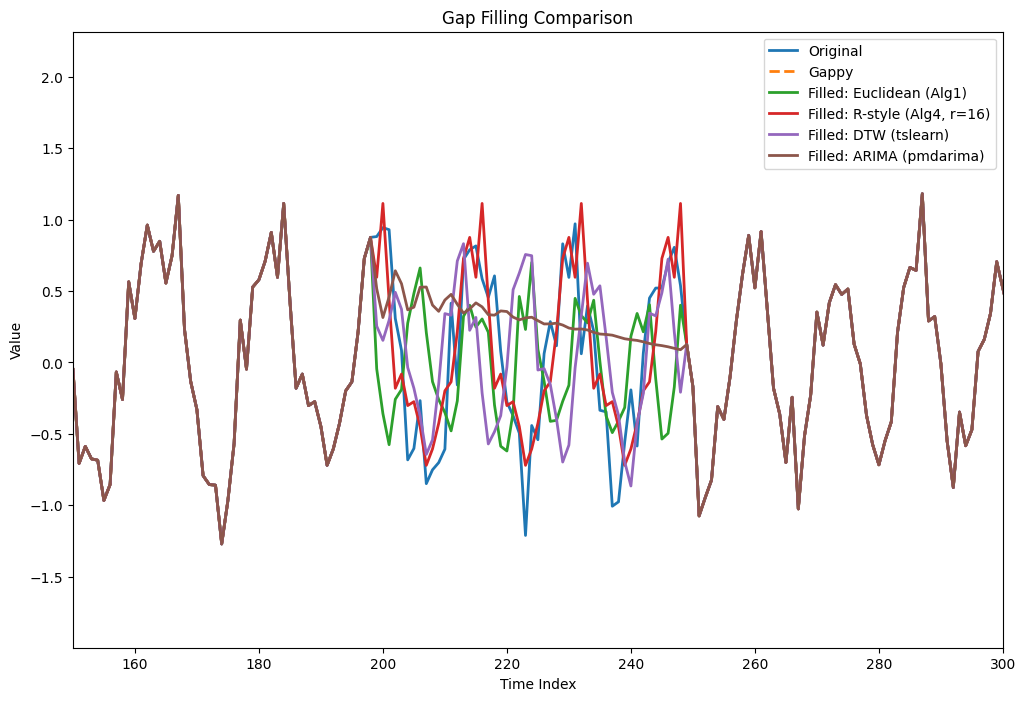

In [22]:
# RMSE Calculation
def compute_rmse(original, filled, gap_indices):
    original_gap = original[gap_indices]
    filled_gap = filled[gap_indices]
    return np.sqrt(np.nanmean((original_gap - filled_gap) ** 2))

# Generate the complete time series.
ts_original = generate_time_series()

# Define gap indices: R's 200:249 corresponds to Python indices 199 to 248.
gap_indices = np.arange(199, 249)
ts_gappy = simulate_gap(ts_original, 199, 248)

# Apply Algorithm 1 (Euclidean Matching) ---
seg_len = 4 * len(gap_indices)  # e.g., if gap length = 50 then seg_len = 200
ts_filled_alg1 = algorithm1_interpolate(ts_original, gap_indices, seg_len=seg_len)
rmse_alg1 = compute_rmse(ts_original, ts_filled_alg1, gap_indices)
print("Algorithm 1 (Euclidean) RMSE:", rmse_alg1)

# Evaluate Algorithm 4 over a range of radius
radius_range = np.arange(1, 51)
rmse_values_alg4 = []
for r in radius_range:
    ts_filled = fill_gap_rstyle(ts_gappy, gap_indices, radius=r)
    rmse = compute_rmse(ts_original, ts_filled, gap_indices)
    rmse_values_alg4.append(rmse)
    print(f"Radius: {r}, RMSE: {rmse:.4f}")

# Plot RMSE versus Radius for Algorithm 4 
plt.figure(figsize=(8,5))
plt.plot(radius_range, rmse_values_alg4, marker='o', linestyle='-')
plt.xlabel("Radius")
plt.ylabel("RMSE")
plt.title("Algorithm 4 (R-style): RMSE vs. Radius")
plt.grid(True)
plt.show()

# Choose the best radius 
best_r = radius_range[np.argmin(rmse_values_alg4)]
best_rmse_alg4 = np.min(rmse_values_alg4)
print(f"Best Radius for Algorithm 4 (R-style): {best_r} with RMSE: {best_rmse_alg4:.4f}")

# Apply Algorithm 4  with the best radius
ts_filled_alg4 = fill_gap_rstyle(ts_gappy, gap_indices, radius=best_r)

# Apply DTW-Based Matching using tslearn 
ts_filled_dtw = algorithm_dtw_interpolate_tslearn(ts_original, gap_indices, seg_len=seg_len)
rmse_dtw = compute_rmse(ts_original, ts_filled_dtw, gap_indices)
print("DTW-based (tslearn) Algorithm RMSE:", rmse_dtw)

# Apply ARIMA-Based Interpolation using pmdarima 
ts_filled_arima = algorithm_arima_interpolate_pmdarima(ts_gappy, gap_indices)
rmse_arima = compute_rmse(ts_original, ts_filled_arima, gap_indices)
print("ARIMA-based (pmdarima) Algorithm RMSE:", rmse_arima)

# Plot the Results 
plt.figure(figsize=(12, 8))
plt.plot(ts_original, label="Original", linewidth=2)
plt.plot(ts_gappy, label="Gappy", linestyle="--", linewidth=2)
plt.plot(ts_filled_alg1, label="Filled: Euclidean (Alg1)", linewidth=2)
plt.plot(ts_filled_alg4, label=f"Filled: R-style (Alg4, r={best_r})", linewidth=2)
plt.plot(ts_filled_dtw, label="Filled: DTW (tslearn)", linewidth=2)
plt.plot(ts_filled_arima, label="Filled: ARIMA (pmdarima)", linewidth=2)
plt.xlim(150, 300)
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.title("Gap Filling Comparison")
plt.show()